In [1]:
import anndata
import lamindb as ln
import lnschema_bionty as lb
import numpy as np
import pandas as pd
import plotnine as p
import scanpy as sc
import scvi
from scvi.hub import HubMetadata, HubModel, HubModelCardHelper
from scvi.model.utils import mde

ln.settings.verbosity = "hint"

✅ wrote new records from public sources.yaml to /home/vale/.lamin/bionty/versions/sources_local.yaml!

if you see this message repeatedly, run: bt.reset_sources()
💡 lamindb instance: vals/scrna


2024-03-07 20:26:20,598:INFO - Created a temporary directory at /tmp/tmpbcihz3xu
2024-03-07 20:26:20,599:INFO - Writing /tmp/tmpbcihz3xu/_remote_module_non_scriptable.py
/home/vale/mambaforge/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
/home/vale/mambaforge/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.


In [2]:
adata = anndata.read_h5ad('mouse_census.h5ad', backed = True)

/home/vale/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [3]:
adata

AnnData object with n_obs × n_vars = 3852436 × 52417 backed at 'mouse_census.h5ad'
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'chunk'

In [5]:
adata.obs['raw_sum']

0          6863.0
1          9467.0
2         17435.0
3          4502.0
4          7043.0
           ...   
192617     8236.0
192618     6381.0
192619     2607.0
192620     1548.0
192621     6483.0
Name: raw_sum, Length: 3852436, dtype: float64

In [7]:
scvi.model.SCVI.setup_anndata(
    adata,
    size_factor_key = 'raw_sum',
)

model = scvi.model.SCVI(
    adata,
    n_latent = 32,
    gene_likelihood = 'nb'
)

In [8]:
model.train(max_epochs = 10, train_size = 0.99, check_val_every_n_epoch = 1)

INFO: GPU available: True (cuda), used: True
2024-03-07 20:30:47,080:INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-03-07 20:30:47,082:INFO - TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-03-07 20:30:47,084:INFO - IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-03-07 20:30:47,086:INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-03-07 20:30:48,968:INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/10:   0%|                                                                                                                                                                                           | 0/10 [00:00<?, ?it/s]

/home/vale/mambaforge/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [7:36:41<00:00, 2690.62s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=1.46e+3]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
2024-03-08 04:07:30,529:INFO - `Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [7:36:41<00:00, 2740.15s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=1.46e+3]


/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 3 in image.
/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: fig1.png
2024-03-08 08:31:37,349:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
2024-03-08 08:31:37,667:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


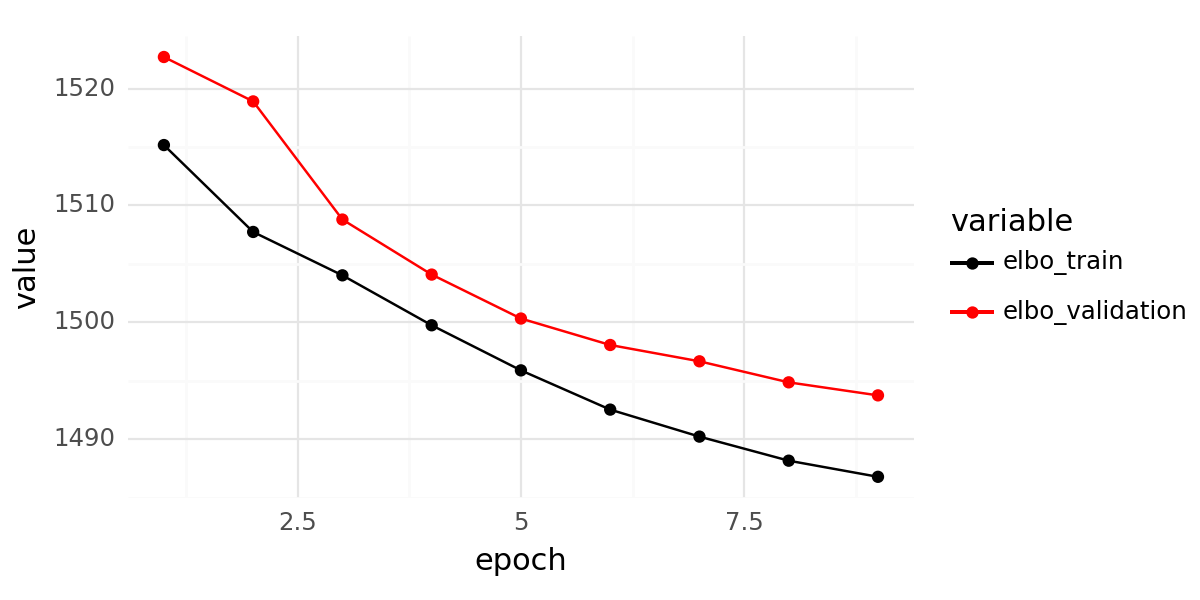

In [9]:
history_df = (
    model.history['elbo_train'].astype(float)
    .join(model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

In [10]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 32, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [11]:
model.save('240308.mouse_census.baseline.model')

In [21]:
adata.obs = adata.obs.set_index('soma_joinid')

/home/vale/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:859: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [356213, 356214, 356215, 356216, 356217]

    Inferred to be: integer



In [28]:
adata.obs.index = adata.obs.index.astype('str')

In [29]:
sample_cells_ids = adata.obs.sample(100_000).index

In [32]:
adata_sample = adata[sample_cells_ids]

In [34]:
adata_sample.write_h5ad('240309.sample.mouse_census.h5ad')

In [35]:
ls

'240306 Download mouse data.ipynb'*        240309.sample.mouse_census.h5ad*
'240307 Fit model maybe.ipynb'*            data/
'240307 Merge data.ipynb'*                 fig1.png*
 240308.mouse_census.baseline.model/       mouse_census.h5ad*
 240308.mouse_census.baseline_20e.model/


In [36]:
adata_sample_l = anndata.read_h5ad('240309.sample.mouse_census.h5ad')

In [37]:
adata_sample_l.obsm['X_scvi'] = model.get_latent_representation(adata_sample_l)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/home/vale/mambaforge/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



In [38]:
adata_sample_l.obsm['X_mde'] = scvi.model.utils.mde(adata_sample_l.obsm['X_scvi'])

for i, y in enumerate(adata_sample_l.obsm['X_mde'].T):
    adata_sample_l.obs[f'mde_{i + 1}'] = y

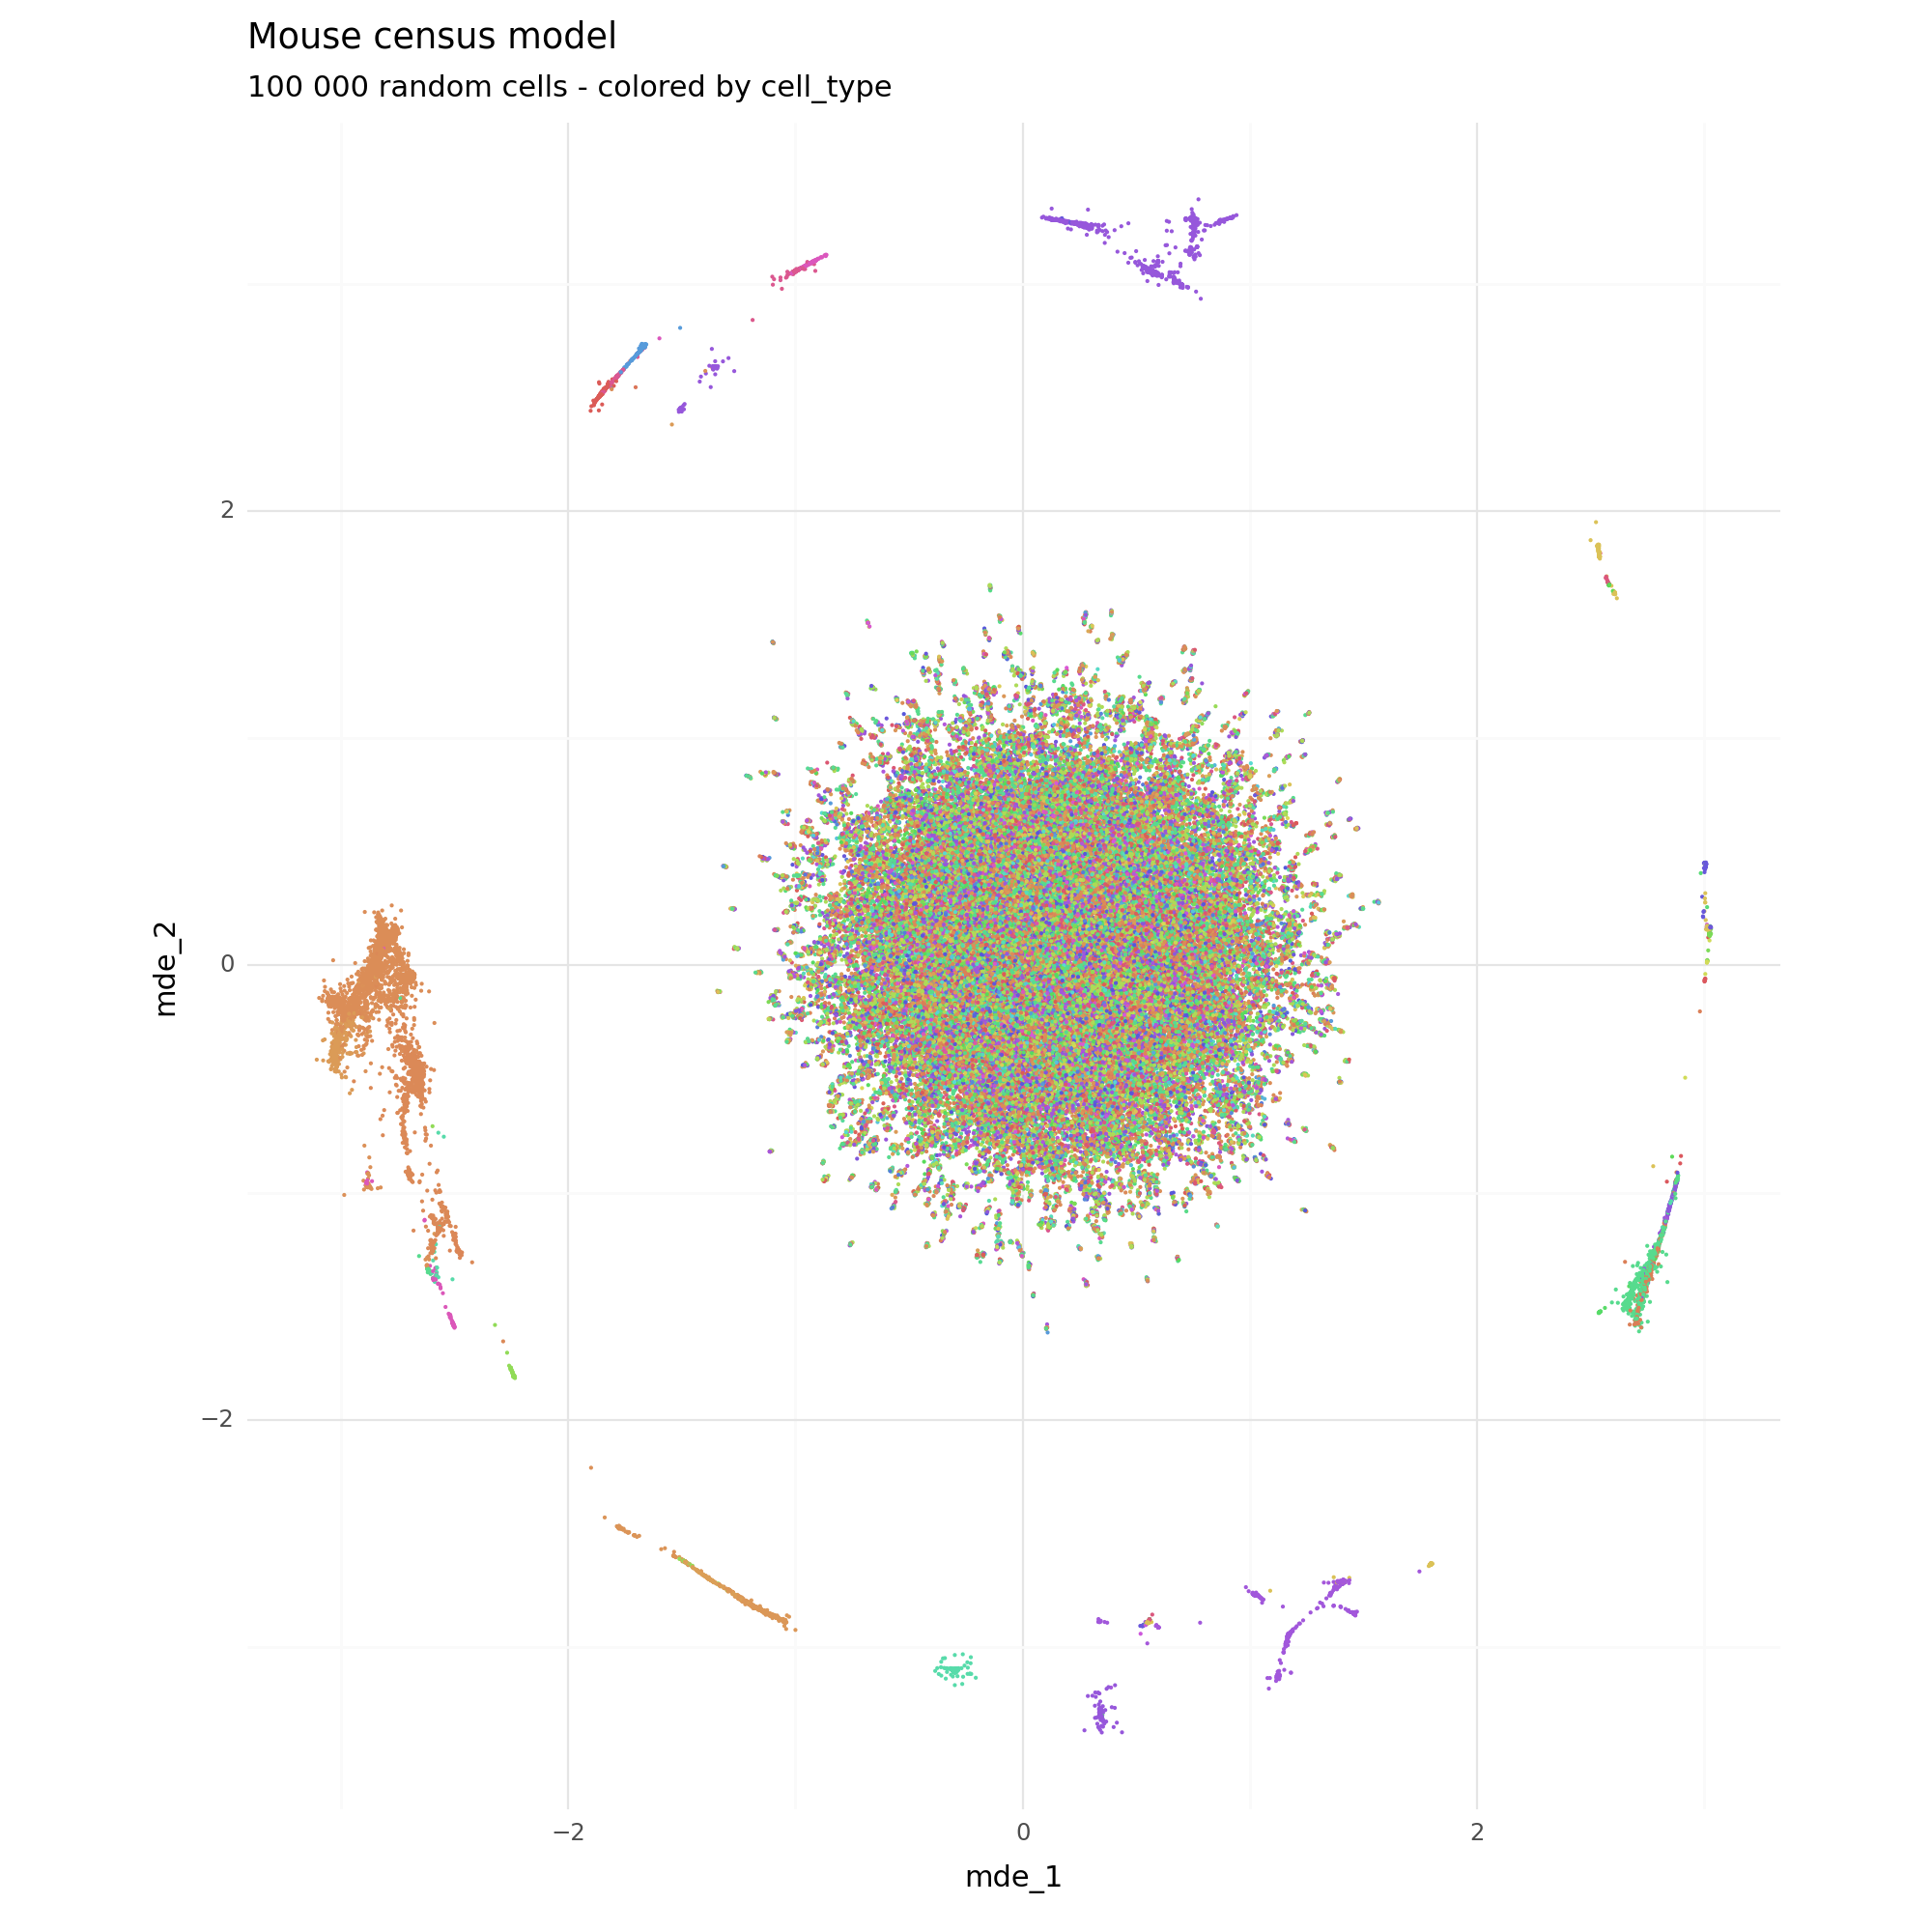

In [46]:
p.options.figure_size = 10, 10

tmp_ = adata_sample_l.obs.copy()

p_ = (
    p.ggplot(p.aes(x = 'mde_1', y = 'mde_2', color = 'cell_type'), tmp_)
    + p.geom_point(shape = '.', size = 0.2)
    + p.coord_equal()
    + p.theme_minimal()
    + p.guides(color = False)
    + p.labs(title = 'Mouse census model', subtitle = '100 000 random cells - colored by cell_type')
)

# p_.save('fig3.png', dpi = 300)

print(p_)

In [48]:
adata_sample_l

AnnData object with n_obs × n_vars = 100000 × 52417
    obs: 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'chunk', '_scvi_batch', '_scvi_labels', 'mde_1', 'mde_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'X_scvi', 'X_mde'

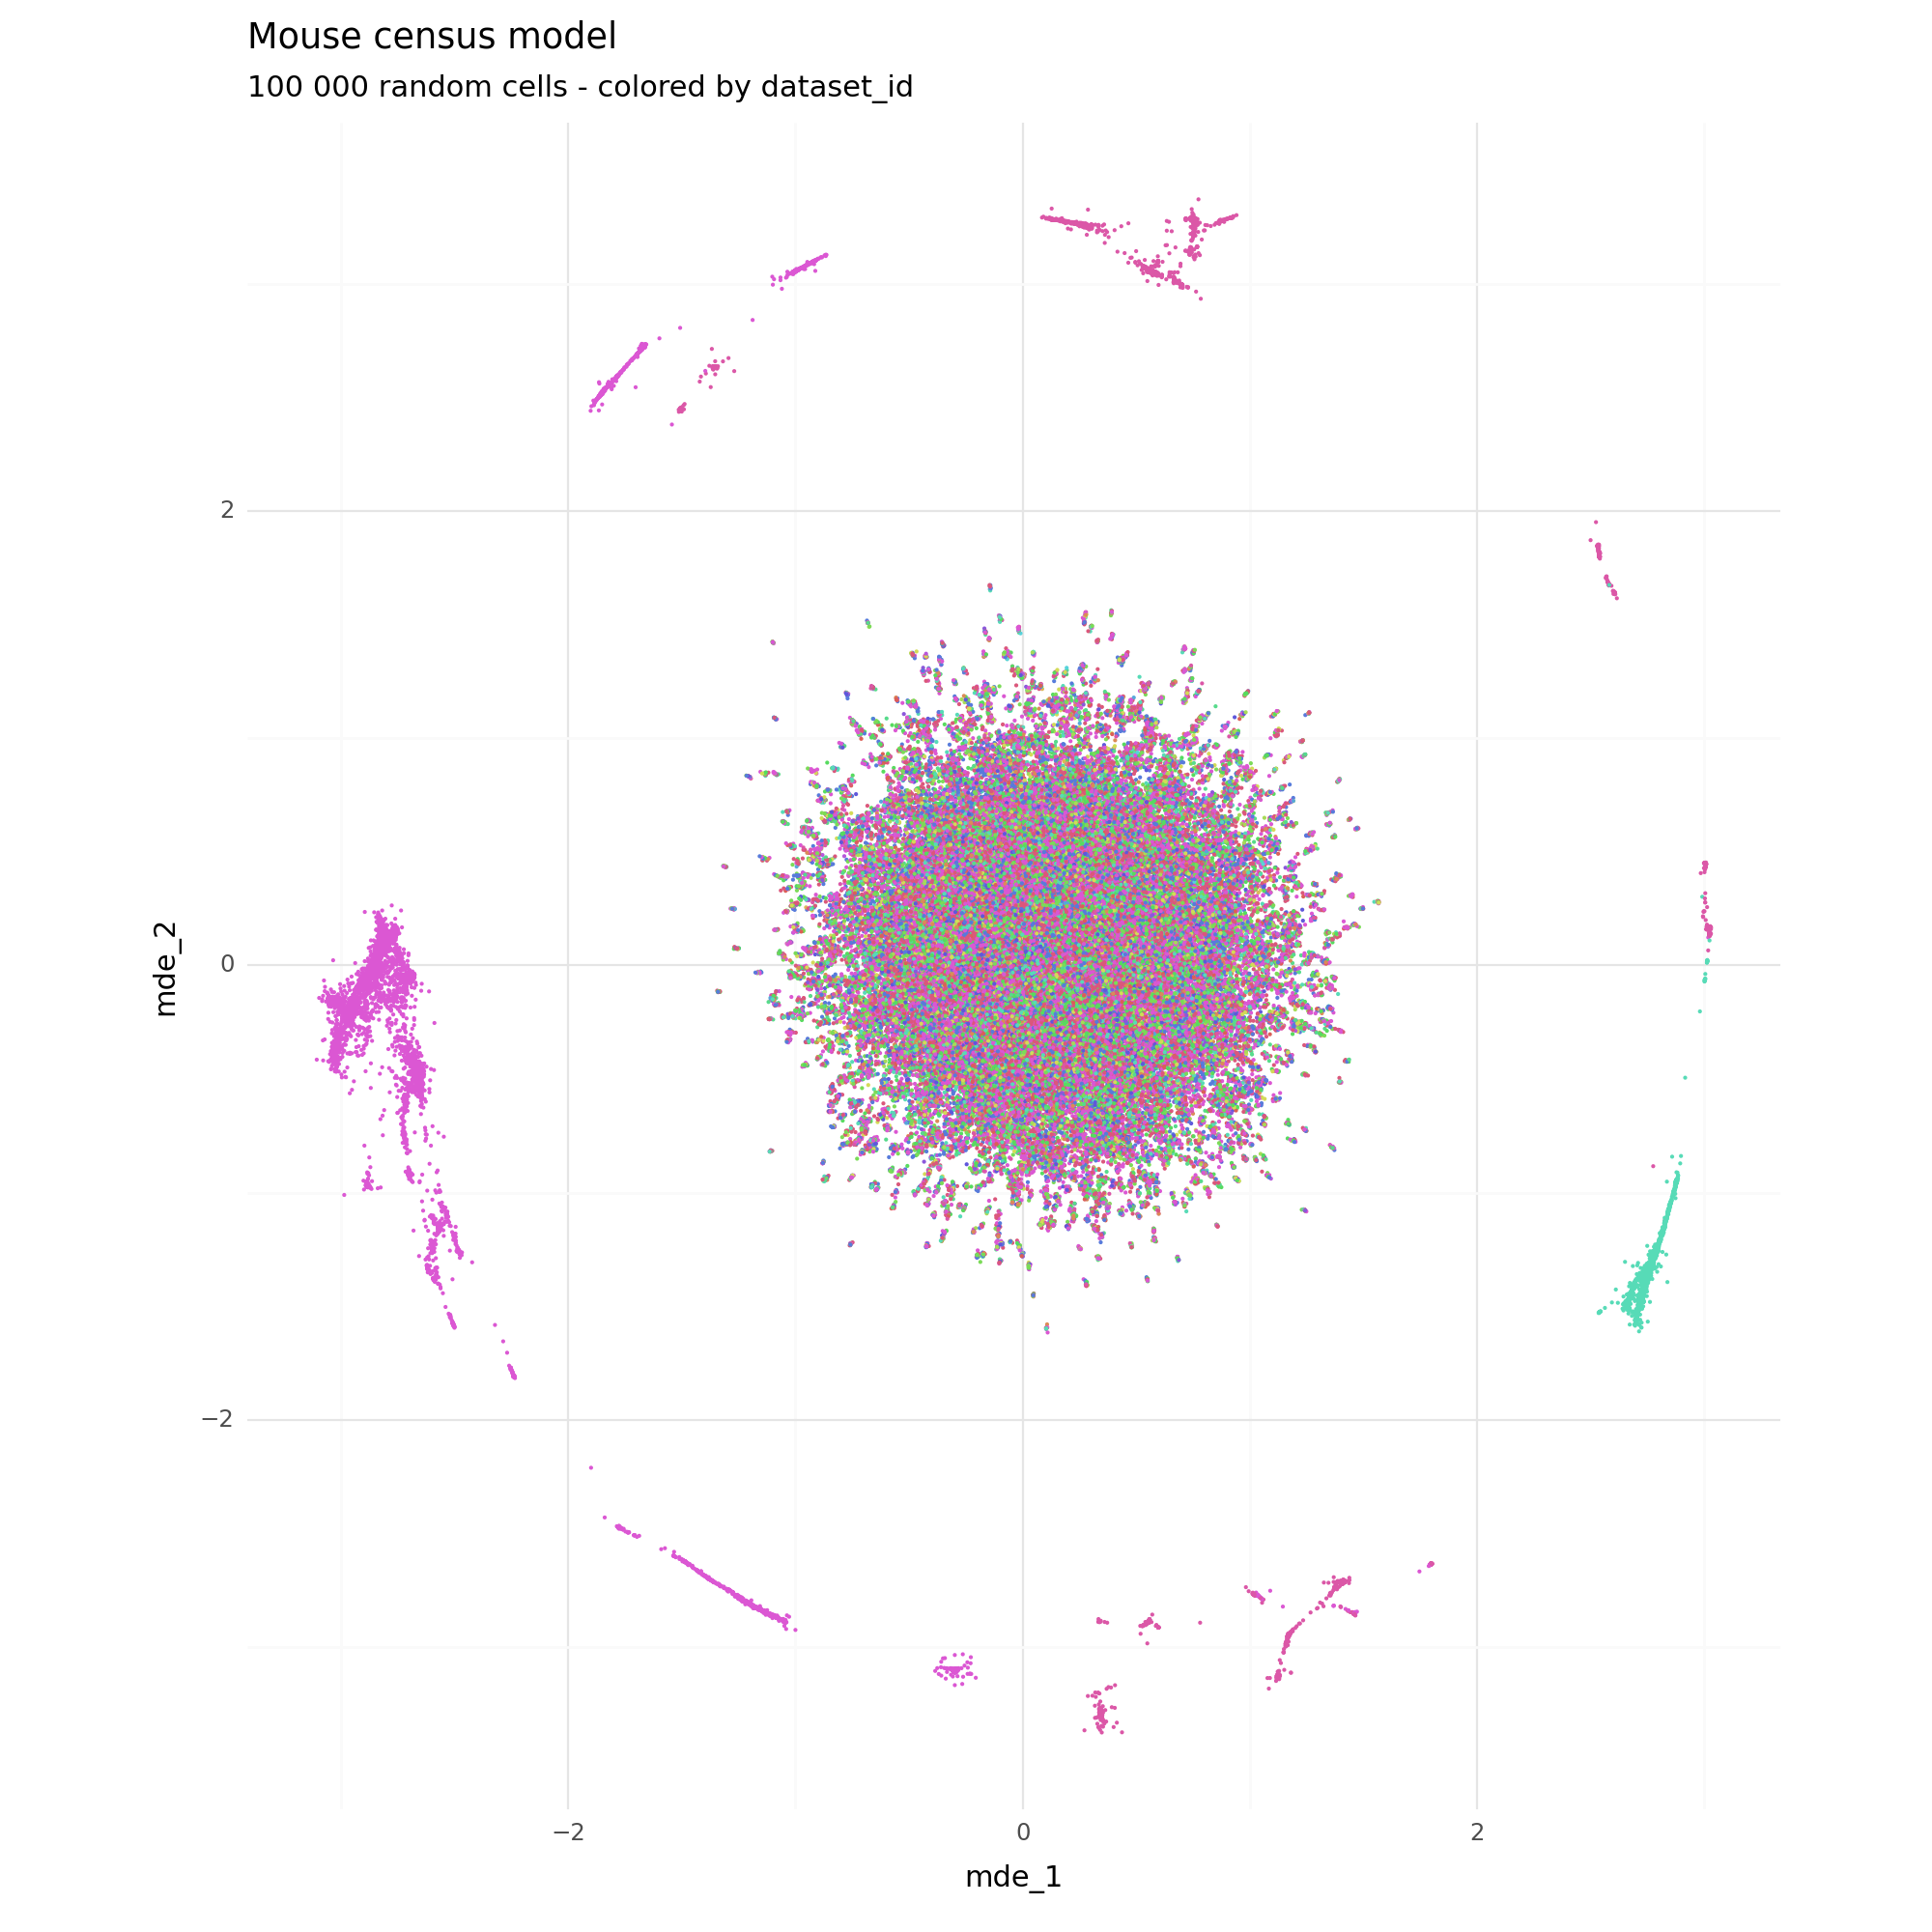

In [50]:
p.options.figure_size = 10, 10

tmp_ = adata_sample_l.obs.copy()

p_ = (
    p.ggplot(p.aes(x = 'mde_1', y = 'mde_2', color = 'dataset_id'), tmp_)
    + p.geom_point(shape = '.', size = 0.2)
    + p.coord_equal()
    + p.theme_minimal()
    + p.guides(color = False)
    + p.labs(title = 'Mouse census model', subtitle = '100 000 random cells - colored by dataset_id')
)

# p_.save('fig3.png', dpi = 300)

print(p_)

In [54]:
adata_sample_small = adata_sample_l[adata_sample_l.obs.sample(100).index].copy()

In [56]:
model.adata = adata_sample_small

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [58]:
model.save('240308.mouse_census.baseline.model', save_anndata = True, overwrite = True)

In [61]:
adata.obs['tissue']

soma_joinid
356213                  parietal cortex
356214                    visual cortex
356215                entorhinal cortex
356216            hippocampal formation
356217     primary somatosensory cortex
                       ...             
2482359                    hypothalamus
2482360                    hypothalamus
2482361                    hypothalamus
2482362                    hypothalamus
2482363                    hypothalamus
Name: tissue, Length: 3852436, dtype: category
Categories (57, object): ['adipose tissue', 'agranular insular cortex', 'anterior cingulate cortex', 'auditory cortex', ..., 'tongue', 'trachea', 'urethra', 'visual cortex']

In [63]:
adata.obs['cell_type']

soma_joinid
356213     L5/6 near-projecting glutamatergic neuron of t...
356214     L4/5 intratelencephalic projecting glutamaterg...
356215     L2/3-6 intratelencephalic projecting glutamate...
356216                                    hippocampal neuron
356217     L6 corticothalamic-projecting glutamatergic co...
                                 ...                        
2482359                                               neuron
2482360                                               neuron
2482361                                               neuron
2482362                                            astrocyte
2482363                                               neuron
Name: cell_type, Length: 3852436, dtype: category
Categories (229, object): ['B cell', 'Bergmann glial cell', 'CD1c-positive myeloid dendritic cell', 'CD4-positive, alpha-beta T cell', ..., 'vascular leptomeningeal cell', 'vascular leptomeningeal cell (Mmus)', 'vein endothelial cell', 'vip GABAergic cortical interne

In [62]:
adata.obs

,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,donor_id,...,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars,chunk,_scvi_batch,_scvi_labels
soma_joinid,,,,,,,,,,,,,,,,,,,,,
356213,d7291f04-fbbb-4d65-990a-f01fa44e915b,10x 3' v2,EFO:0009899,L5/6 near-projecting glutamatergic neuron of t...,CL:4023043,7 weeks,MmusDv:0000051,normal,PATO:0000461,412866,...,brain,UBERON:0000955,6863.0,3172,2.163619,9.942631,28208,0.h5ad,0,0
356214,d7291f04-fbbb-4d65-990a-f01fa44e915b,10x 3' v2,EFO:0009899,L4/5 intratelencephalic projecting glutamaterg...,CL:4023048,8 weeks,MmusDv:0000052,normal,PATO:0000461,366678,...,brain,UBERON:0000955,9467.0,3936,2.405234,52.933330,28208,0.h5ad,0,0
356215,d7291f04-fbbb-4d65-990a-f01fa44e915b,10x 3' v2,EFO:0009899,L2/3-6 intratelencephalic projecting glutamate...,CL:4023040,7 weeks,MmusDv:0000051,normal,PATO:0000461,380340,...,brain,UBERON:0000955,17435.0,5552,3.140310,40.298991,28208,0.h5ad,0,0
356216,d7291f04-fbbb-4d65-990a-f01fa44e915b,10x 3' v2,EFO:0009899,hippocampal neuron,CL:0002608,7 weeks,MmusDv:0000051,normal,PATO:0000461,374165,...,brain,UBERON:0000955,4502.0,2371,1.898777,9.933209,28208,0.h5ad,0,0
356217,d7291f04-fbbb-4d65-990a-f01fa44e915b,10x 3' v2,EFO:0009899,L6 corticothalamic-projecting glutamatergic co...,CL:4023042,8 weeks,MmusDv:0000052,normal,PATO:0000461,410107,...,brain,UBERON:0000955,7043.0,3198,2.202314,18.833939,28208,0.h5ad,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482359,dbb4e1ed-d820-4e83-981f-88ef7eb55a35,10x 3' v2,EFO:0009899,neuron,CL:0000540,2 month-old stage,MmusDv:0000062,normal,PATO:0000461,pooled,...,brain,UBERON:0000955,8236.0,3563,2.311535,14.232509,46513,9.h5ad,0,0
2482360,dbb4e1ed-d820-4e83-981f-88ef7eb55a35,10x 3' v2,EFO:0009899,neuron,CL:0000540,2 month-old stage,MmusDv:0000062,normal,PATO:0000461,pooled,...,brain,UBERON:0000955,6381.0,2803,2.276489,25.157288,46513,9.h5ad,0,0
2482361,dbb4e1ed-d820-4e83-981f-88ef7eb55a35,10x 3' v2,EFO:0009899,neuron,CL:0000540,2 month-old stage,MmusDv:0000062,normal,PATO:0000461,pooled,...,brain,UBERON:0000955,2607.0,1571,1.659453,8.382680,46513,9.h5ad,0,0


In [60]:
adata.obs['dataset_id']

soma_joinid
356213     d7291f04-fbbb-4d65-990a-f01fa44e915b
356214     d7291f04-fbbb-4d65-990a-f01fa44e915b
356215     d7291f04-fbbb-4d65-990a-f01fa44e915b
356216     d7291f04-fbbb-4d65-990a-f01fa44e915b
356217     d7291f04-fbbb-4d65-990a-f01fa44e915b
                           ...                 
2482359    dbb4e1ed-d820-4e83-981f-88ef7eb55a35
2482360    dbb4e1ed-d820-4e83-981f-88ef7eb55a35
2482361    dbb4e1ed-d820-4e83-981f-88ef7eb55a35
2482362    dbb4e1ed-d820-4e83-981f-88ef7eb55a35
2482363    dbb4e1ed-d820-4e83-981f-88ef7eb55a35
Name: dataset_id, Length: 3852436, dtype: category
Categories (18, object): ['2a262b59-7936-4ecd-b656-248247a0559f', '3bbb6cf9-72b9-41be-b568-656de6eb18b5', '26ae14da-9e5f-4d18-abae-18a5a328feef', '42bb7f78-cef8-4b0d-9bba-50037d64d8c1', ..., 'a539c7af-fb65-44b1-8812-000b097eac99', 'd7291f04-fbbb-4d65-990a-f01fa44e915b', 'dbb4e1ed-d820-4e83-981f-88ef7eb55a35', 'e0ed3c55-aff6-4bb7-b6ff-98a2d90b890c']